In [66]:
import os
import re
import opendatasets as od
from itertools import product
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

Data Extraction

In [67]:
data = 'https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data'
od.download(data)
file_paths = os.listdir('./competitive-data-science-predict-future-sales')
df_s = list(map(lambda path: pd.read_csv(f'./competitive-data-science-predict-future-sales/{path}'), file_paths))

Skipping, found downloaded files in ".\competitive-data-science-predict-future-sales" (use force=True to force download)


In [68]:
for df in df_s:
    print(df.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00

Validity: Outliers detection

In [69]:
def outlier_detection(df, series):
    data_mean = series.mean()
    data_std = series.std()
    low= data_mean -(3 * data_std)
    high= data_mean + (3 * data_std)
    outliers = df[(series < low) | (series > high)]
    percentage = len(outliers)/len(df)
    print(f'Percentage of outliers = {percentage:.2%}')
    return outliers

In [70]:
outliers = outlier_detection(df_s[2], df_s[2]['item_cnt_day'])

Percentage of outliers = 0.41%


In [71]:
df_s[2] = df_s[2][~df_s[2].isin(outliers)].dropna()

In [72]:
outliers = outlier_detection(df_s[2], df_s[2]['item_price'])

Percentage of outliers = 0.98%


In [73]:
df_s[2] = df_s[2][~df_s[2].isin(outliers)].dropna()

Consistency: shop_name correction

In [74]:
pattern1 = "^!"
pattern2 = ""
for name in df_s[4]['shop_name'].unique():
    df_s[4].replace({'shop_name': {name: re.sub(pattern1, pattern2, name)}}, inplace = True)

In [75]:
df_s[4]['shop_name'].unique()

array(['Якутск Орджоникидзе, 56 фран', 'Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва ТЦ 

Completeness and Uniqueness check: NAN values and duplicates

In [76]:
for i in range(len(df_s)):
    if df_s[i].isna().values.any():
        print(df_s[i].loc[df_s[i].isna().any(axis=1)])
        print(f'Percentage of missing values: {(df_sales_train.isna().any().sum()/len(df_s[i])):.4%}')
    if df_s[i].duplicated(keep = False).values.any():
        print(df_s[i][df_s[i].duplicated()])
        print(f'\nPercentage of duplicates in df_s[{i}]: {(df_s[i].duplicated().sum()/len(df_s[i])):.4%}')

               date  date_block_num  shop_id  item_id  item_price  \
76962    05.01.2013             0.0     54.0  20130.0       149.0   
1435367  23.02.2014            13.0     50.0   3423.0       999.0   
1496766  23.03.2014            14.0     21.0   3423.0       999.0   
1671873  01.05.2014            16.0     50.0   3423.0       999.0   
1866340  12.07.2014            18.0     25.0   3423.0       999.0   
2198566  31.12.2014            23.0     42.0  21619.0       499.0   

         item_cnt_day  
76962             1.0  
1435367           1.0  
1496766           1.0  
1671873           1.0  
1866340           1.0  
2198566           1.0  

Percentage of duplicates in df_s[2]: 0.0002%


In [77]:
df_items = df_s[0]
df_item_categories = df_s[1]
df_sales_train = df_s[2]
df_sample_submission = df_s[3]
df_shops = df_s[4]
df_test = df_s[5]

Itegrity data by int_snt_month

In [78]:
df_sales_per_month = df_sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg({'item_cnt_day':'sum'})
df_sales_per_month = df_sales_per_month.rename({"item_cnt_day":"item_cnt_month"}, axis=1)
df_sales_per_month.reset_index(inplace = True)

As in future we will use item_cnt_month, creating new column revenue

In [79]:
df_sales_train['revenue'] = df_sales_train['item_price'] * df_sales_train['item_cnt_day']
df_revenue_per_month = df_sales_train.groupby(["date_block_num", "shop_id"]).agg({'revenue':'sum'})
df_revenue_per_month = df_revenue_per_month.rename({"revenue":"month_revenue"}, axis=1)
df_revenue_per_month.reset_index(inplace=True)

Uniqueness: Check similar named shops

In [80]:
for id in df_sales_per_month['shop_id'].unique():
    if df_sales_per_month[df_sales_per_month['shop_id'] == id].reset_index(drop = True)['date_block_num'].nunique() != 34:
        print(df_shops.loc[df_shops.shop_id == id, 'shop_name'].min())

Якутск Орджоникидзе, 56 фран
Якутск ТЦ "Центральный" фран
Воронеж ТРЦ Сити-Парк "Град"
Жуковский ул. Чкалова 39м?
Казань ТЦ "Бехетле"
Москва ТК "Буденовский" (пав.А2)
Москва ТЦ "МЕГА Белая Дача II"
Москва ТЦ "Новый век" (Новокосино)
Москва ТЦ "Перловский"
Москва ТЦ "Серебряный Дом"
СПб ТК "Сенная"
Тюмень ТЦ "Зеленый Берег"
Химки ТЦ "Мега"
Вологда ТРЦ "Мармелад"
Якутск Орджоникидзе, 56
Якутск ТЦ "Центральный"
Цифровой склад 1С-Онлайн
Красноярск ТЦ "Взлетка Плаза"
Выездная Торговля
Тюмень ТРЦ "Кристалл"
РостовНаДону ТРК "Мегацентр Горизонт"
РостовНаДону ТРК "Мегацентр Горизонт" Островной
Томск ТРЦ "Изумрудный Город"
Н.Новгород ТРЦ "РИО"
Мытищи ТРК "XL-3"
Москва "Распродажа"
Жуковский ул. Чкалова 39м²
Новосибирск ТРЦ "Галерея Новосибирск"


In [81]:
def shop_name_check(shop_name_1, shop_name_2):
    shop_id1 = df_shops.loc[df_shops.shop_name == shop_name_1, 'shop_id'].min()
    c1 = df_sales_per_month[df_sales_per_month['shop_id'] == shop_id1].reset_index(drop = True)
    c1 = pd.DataFrame(c1.groupby('date_block_num').agg({'item_cnt_month': 'mean'}))

    shop_id2 = df_shops.loc[df_shops.shop_name == shop_name_2, 'shop_id'].min()
    c2 = df_sales_per_month[df_sales_per_month['shop_id'] == shop_id2].reset_index(drop = True)
    c2 = pd.DataFrame(c2.groupby('date_block_num').agg({'item_cnt_month': 'mean'}))
    
    plt.figure(figsize = (10,6))

    plt.bar(c1.index, c1['item_cnt_month'], color = 'g', label = shop_name_1, alpha = 0.8)
    plt.bar(c2.index, c2['item_cnt_month'], color = 'b', label = shop_name_2, alpha = 0.7)

    plt.xticks(range(0,34));
    plt.legend()
    plt.xlabel('Date_block_num')
    plt.ylabel('item_cnt_month')
    plt.title('Shops comparison')

    plt.show()


pair 1.Якутск Орджоникидзе, 56 фран and Якутск Орджоникидзе, 56

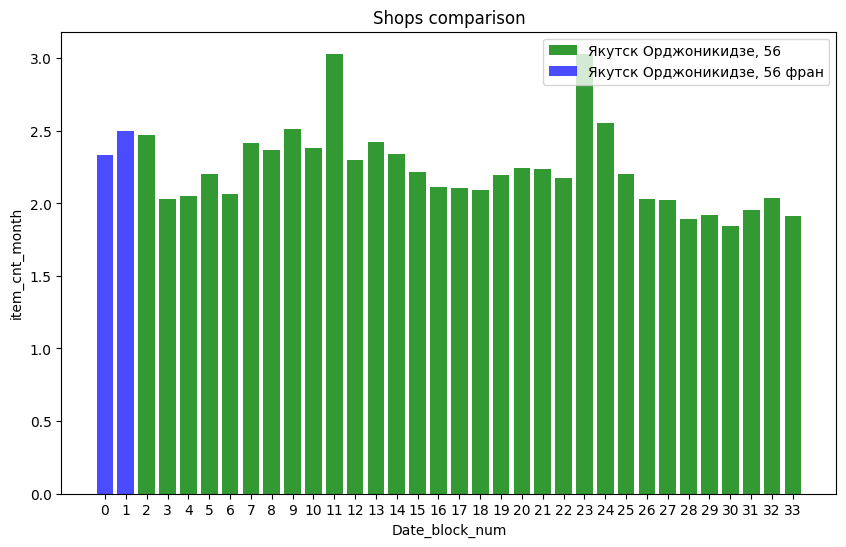

In [82]:
shop_name_check('Якутск Орджоникидзе, 56', 'Якутск Орджоникидзе, 56 фран')

Combining them - we'll get full range of data

In [83]:
def shop_corr(shop_name_1, shop_name_2):
    shop_id1 = df_shops.loc[df_shops.shop_name == shop_name_1, 'shop_id'].min()
    shop_id2 = df_shops.loc[df_shops.shop_name == shop_name_2, 'shop_id'].min()
    df_sales_per_month.replace({'shop_id': {shop_id2: shop_id1}}, inplace = True)
    df_test.replace({'shop_id': {shop_id2: shop_id1}}, inplace = True)

In [84]:
shop_corr('Якутск Орджоникидзе, 56', 'Якутск Орджоникидзе, 56 фран')

Якутск ТЦ "Центральный" фран, Якутск ТЦ "Центральный"

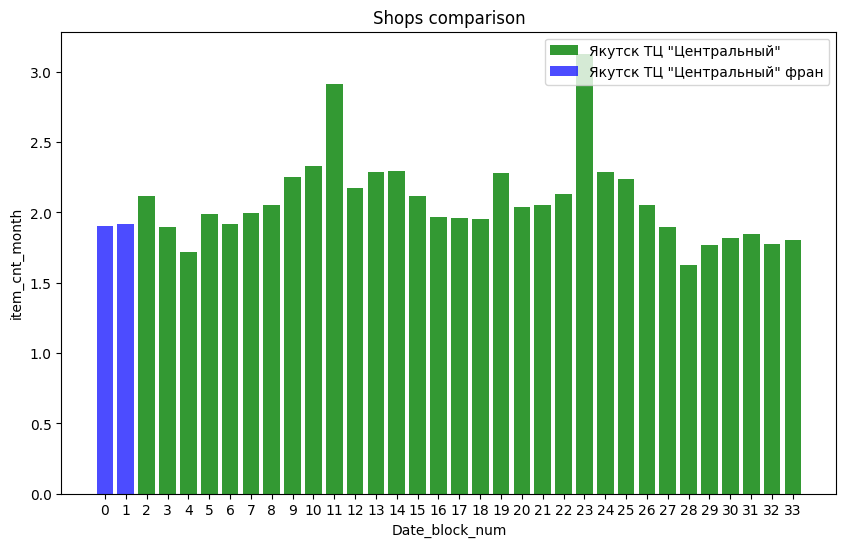

In [85]:
shop_name_check('Якутск ТЦ "Центральный"', 'Якутск ТЦ "Центральный" фран')

In [86]:
shop_corr('Якутск ТЦ "Центральный"', 'Якутск ТЦ "Центральный" фран')

Жуковский ул. Чкалова 39м?, Жуковский ул. Чкалова 39м²

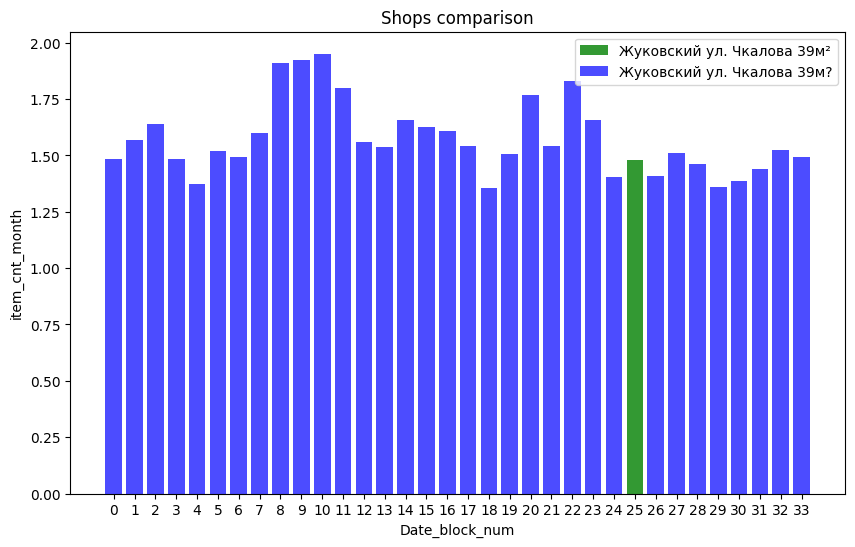

In [87]:
shop_name_check('Жуковский ул. Чкалова 39м²', 'Жуковский ул. Чкалова 39м?')

In [88]:
shop_corr('Жуковский ул. Чкалова 39м²', 'Жуковский ул. Чкалова 39м?')

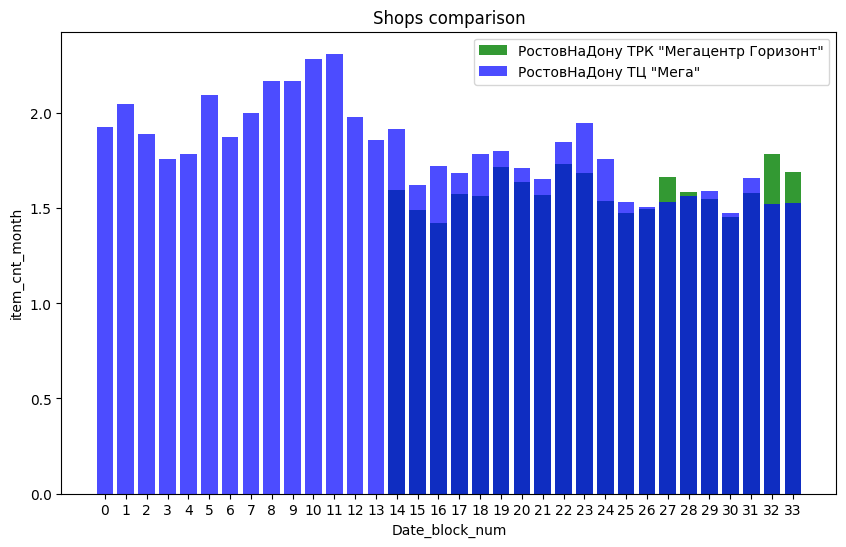

In [89]:
shop_name_1 = 'РостовНаДону ТРК "Мегацентр Горизонт"'
shop_name_2 = 'РостовНаДону ТЦ "Мега"'
shop_name_check(shop_name_1, shop_name_2)


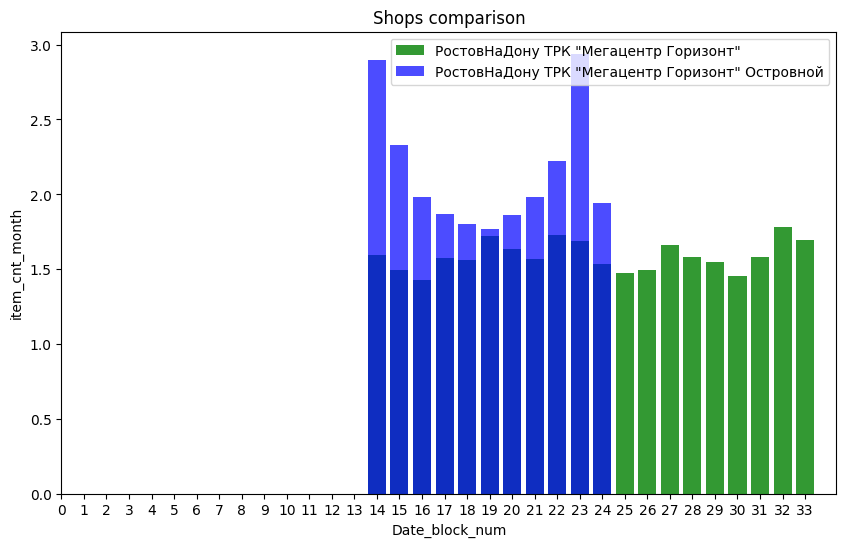

In [90]:
shop_name_1 = 'РостовНаДону ТРК "Мегацентр Горизонт"'
shop_name_2 = 'РостовНаДону ТРК "Мегацентр Горизонт" Островной'
shop_name_check(shop_name_1, shop_name_2)


So, as we do not get the full group - we will not combine them

Validity: Encoding of non-numerical data

In [91]:
df_shops.head()

,shop_name,shop_id
0,"Якутск Орджоникидзе, 56 фран",0
1,"Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


We have for each shop id, but in one city could be several shops(creating new feature)

In [92]:
df_shops['city'] = df_shops['shop_name'].str.split(' ').apply(lambda x: x[0])
df_shops.head()

,shop_name,shop_id,city
0,"Якутск Орджоникидзе, 56 фран",0,Якутск
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [93]:
encoder = LabelEncoder()
df_shops['city_code'] = encoder.fit_transform(df_shops['city'])
df_shops = df_shops[['shop_id', 'city_code']]
df_shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [94]:
df_item_categories['item_category_name'].unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

We have for each category id, but groups of categories with different "id" have the same first word, that can be also be category(main), and almost all have second word
That can be second category (minor) - new features

In [95]:
df_item_categories['main_category'] = df_item_categories['item_category_name'].str.split(' - ').apply(lambda x: x[0])
df_item_categories['main_category_code'] = encoder.fit_transform(df_item_categories['main_category'])

In [96]:
df_item_categories.head()

,item_category_name,item_category_id,main_category,main_category_code
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1


In [97]:
df_item_categories['minor_category'] = df_item_categories['item_category_name'].str.split(' - ').apply(lambda x: x[1] if len(x) > 1 else x[0])
df_item_categories['minor_category'].head()

0    Гарнитуры/Наушники
1                   PS2
2                   PS3
3                   PS4
4                   PSP
Name: minor_category, dtype: object

In [98]:
df_item_categories['minor_category_code'] = encoder.fit_transform(df_item_categories['minor_category'])
df_item_categories.head()

,item_category_name,item_category_id,main_category,main_category_code,minor_category,minor_category_code
0,PC - Гарнитуры/Наушники,0,PC,0,Гарнитуры/Наушники,31
1,Аксессуары - PS2,1,Аксессуары,1,PS2,11
2,Аксессуары - PS3,2,Аксессуары,1,PS3,12
3,Аксессуары - PS4,3,Аксессуары,1,PS4,13
4,Аксессуары - PSP,4,Аксессуары,1,PSP,15


In [99]:
df_item_categories = df_item_categories[['item_category_id', 'main_category_code', 'minor_category_code']]
df_item_categories.head()

,item_category_id,main_category_code,minor_category_code
0,0,0,31
1,1,1,11
2,2,1,12
3,3,1,13
4,4,1,15


In [100]:
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [101]:
df_items = df_items[['item_id', 'item_category_id']]

Completeness: counting data that are not present training set that we need to predict

In [102]:
count = 0
for id in df_test.item_id.unique():
    if len(df_sales_per_month[df_sales_per_month.item_id == id]) == 0:
        count += 1
print(f'The total amount of Data that not presenting in train set is {count}')

The total amount of Data that not presenting in train set is 407


counting data that have uncomplete time series range

In [103]:
Count = 0
for id in df_sales_per_month.item_id.unique():
    if df_sales_per_month[df_sales_per_month.shop_id == id].date_block_num.unique != 34:
        count += 1
print(f'The total amount of missing times series data in train set is {count}')

The total amount of missing times series data in train set is 21976


Completeness: Get the full data for full time series range and fill NAN with 0

In [104]:
df_sales_per_month.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0.0,57.0,32.0,6.0
1,0.0,57.0,33.0,3.0
2,0.0,57.0,35.0,1.0
3,0.0,57.0,43.0,1.0
4,0.0,57.0,51.0,2.0


In [105]:
total_data = []

for i in range(34):
    sales = df_sales_per_month[df_sales_per_month.date_block_num==i]
    total_data.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique()))))

columns = ['date_block_num','shop_id','item_id']
total_data = pd.DataFrame(np.vstack(total_data), columns=columns)
total_data.sort_values(by = columns, inplace = True)

In [106]:
total_data = total_data.merge(df_sales_per_month, on = columns, how = 'left')
total_data.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0.0,2.0,19.0,NaN
1,0.0,2.0,27.0,1.0
2,0.0,2.0,28.0,NaN
3,0.0,2.0,29.0,NaN
4,0.0,2.0,32.0,NaN


In [107]:
total_data.isna().sum()

date_block_num          0
shop_id                 0
item_id                 0
item_cnt_month    9222442
dtype: int64

In [108]:
total_data['item_cnt_month'] = total_data['item_cnt_month'].fillna(0)

Completeness and Adding data from test set that not in our train set

In [109]:
df_test['date_block_num'] = 34
total_data = pd.concat([total_data, df_test], ignore_index=True, sort=False, keys=columns)
total_data.isna().sum()

C:\Users\User\AppData\Local\Temp\ipykernel_29804\4067152389.py:2: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  total_data = pd.concat([total_data, df_test], ignore_index=True, sort=False, keys=columns)


date_block_num           0
shop_id                  0
item_id                  0
item_cnt_month      214200
ID                10816635
dtype: int64

In [110]:
total_data.drop('ID', axis = 1, inplace = True)
total_data = total_data.fillna(0)

Integrity of data

In [111]:
merge_params = [[df_items, 'item_id'], [df_item_categories, 'item_category_id'], [df_shops, 'shop_id'], [df_revenue_per_month, ['date_block_num', 'shop_id']]]
for params in merge_params:
    total_data = pd.merge(total_data, params[0], on = params[1], how = 'left')
total_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,main_category_code,minor_category_code,city_code,month_revenue
0,0.0,2.0,19.0,0.0,40,11,6,0,827666.3
1,0.0,2.0,27.0,1.0,19,5,12,0,827666.3
2,0.0,2.0,28.0,0.0,30,8,57,0,827666.3
3,0.0,2.0,29.0,0.0,23,5,18,0,827666.3
4,0.0,2.0,32.0,0.0,40,11,6,0,827666.3


ETL - load

In [112]:
total_data.to_csv('total_data.csv')